# Loading in some data

The below cell loads in a geodata frame -- this is like a fancy excel spreadsheet (a.k.a. pandas dataframe), where each row of the spreadsheet contains information of a precinct in Texas.

Let's print out the first 5 rows of this dataframe to see what kind of data it contains.

In [1]:
import geopandas as gpd

precinct_gdf = gpd.read_file("data/TX_precincts_24/TX_precincts24_with_pop.shp")
# fill nan values in VAP20 with 0
precinct_gdf["VAP20"] = precinct_gdf["VAP20"].fillna(0)
precinct_gdf.head(5)

,PRECINCT,COUNTY,CD25,Incumbent2,TOTPOP20,VAP20,BVAP20,HVAP20,AAPIVAP20,AMINVAP20,WVAP20,DVAP22,BDVAP22,HDVAP22,AAPIDVAP22,AMINDVAP22,WDVAP22,geometry
0,1890420,189,19,0,576.0,445.0,4.0,108.0,4.0,3.0,326.0,415.476431,3.977186,93.851003,4.000000,3.000000,310.648241,"POLYGON ((226335.861 3790308.843, 226333.648 3..."
1,1890419,189,19,0,460.0,322.0,0.0,111.0,3.0,3.0,205.0,290.361465,0.000000,92.753425,3.000000,3.000000,191.608040,"POLYGON ((226333.648 3790236.182, 226335.861 3..."
2,1890304,189,19,0,1503.0,1077.0,67.0,476.0,18.0,12.0,504.0,990.184097,63.823529,406.286882,7.230769,9.785325,503.057592,"POLYGON ((248062.528 3787449.003, 248193.83 37..."
3,1890306,189,19,0,214.0,142.0,17.0,82.0,3.0,3.0,37.0,138.702145,17.000000,79.255814,3.000000,2.446331,37.000000,"POLYGON ((247760.43 3786634.764, 247783.302 37..."
4,650402,65,13,0,408.0,323.0,4.0,13.0,1.0,14.0,291.0,319.265423,4.000000,13.000000,0.667201,11.416212,290.182010,"POLYGON ((292770.184 3944754.408, 293383.841 3..."


Each column carries some demographic information about the precincts: for example, "VAP20" stands for the Voting Age Population recorded by the 2020 census in each precinct, and "BVAP20" stands for the recorded Black Voting Age Population.

Because this is a *__geo__*dataframe, the last column carries information about the geometry of each precinct, which we can use to plot the full map of Texas precincts:

<Axes: >

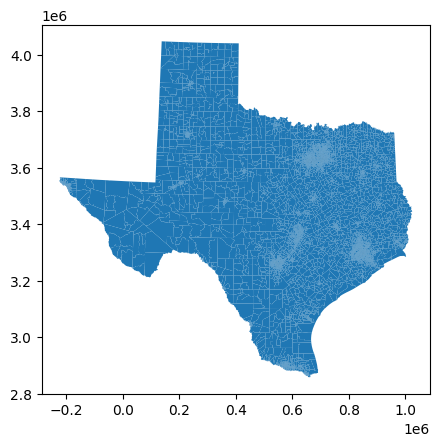

In [2]:
precinct_gdf.plot()

Let's also load in the proposed 2025 redistricting -- this is a partition of Texas's precincts into 38 congressional districts. 

Number of NaN values replaced with 0: 74
Adding 30 edges to connect district 11
Adding 5 edges to connect district 12
Adding 15 edges to connect district 10
Adding 5 edges to connect district 20
Adding 5 edges to connect district 29
Adding 5 edges to connect district 2


<Axes: >

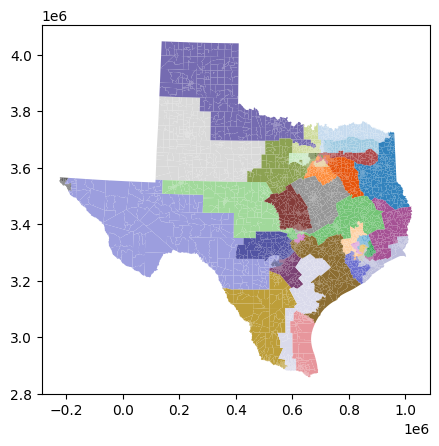

In [47]:
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally
from src.custom_cmap import custom_cmap
from src.partition_contiguator import contiguate

tx_graph = Graph.from_json("data/TX_precincts_24/TX_precincts24_with_pop_and_elections.json")

tx_partition = Partition(tx_graph, assignment="CD25", updaters={"VAP": Tally("VAP20", alias="VAP20")})

number_of_nans = 0
for node in tx_graph.nodes:
    if tx_graph.nodes[node]["VAP20"] != tx_partition.graph.nodes[node]["VAP20"]:
        tx_graph.nodes[node]["VAP20"] = 0
        number_of_nans += 1
    if tx_graph.nodes[node]["BVAP20"] != tx_partition.graph.nodes[node]["BVAP20"]:
        tx_graph.nodes[node]["BVAP20"] = 0
    if tx_graph.nodes[node]["HarrisD_PRSG24"] != tx_partition.graph.nodes[node]["HarrisD_PRSG24"]:
        tx_graph.nodes[node]["HarrisD_PRSG24"] = 0
    if tx_graph.nodes[node]["TrumpR_PRSG24"] != tx_partition.graph.nodes[node]["TrumpR_PRSG24"]:
        tx_graph.nodes[node]["TrumpR_PRSG24"] = 0
print(f"Number of NaN values replaced with 0: {number_of_nans}")
modified_tx_graph = contiguate(tx_graph, tx_partition)

tx_partition = Partition(modified_tx_graph, assignment="CD25", updaters={"VAP": Tally("VAP20", alias="VAP20")})

tx_partition.plot(geometries=precinct_gdf, cmap = custom_cmap)

# Running a Recom Markov Chain

Recombination is a way to use a current districting to draw a new one -- we merge two districts together, then split them up into two new districts in a smart way. If we do this many times, we can generate an ensemble of plans to compare to the 2025 map.

In [48]:
from gerrychain import MarkovChain
from gerrychain.constraints import contiguous
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
from gerrychain.tree import bipartition_tree

partition_len = len(tx_partition)
ideal_population = sum(tx_partition["VAP"].values()) / partition_len

proposal = partial(
    recom,
    pop_col="VAP20",
    pop_target=ideal_population,
    epsilon=0.05,
    node_repeats=10,
    method = partial(
        bipartition_tree,
        max_attempts = 100,
        allow_pair_reselection = True
    )
)

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=always_accept,
    initial_state=tx_partition,
    total_steps=1000
)

assignment_list = []

for i, item in enumerate(recom_chain):
    print(f"Finished step {i+1}/{len(recom_chain)}", end="\r")
    assignment_list.append(item.assignment)

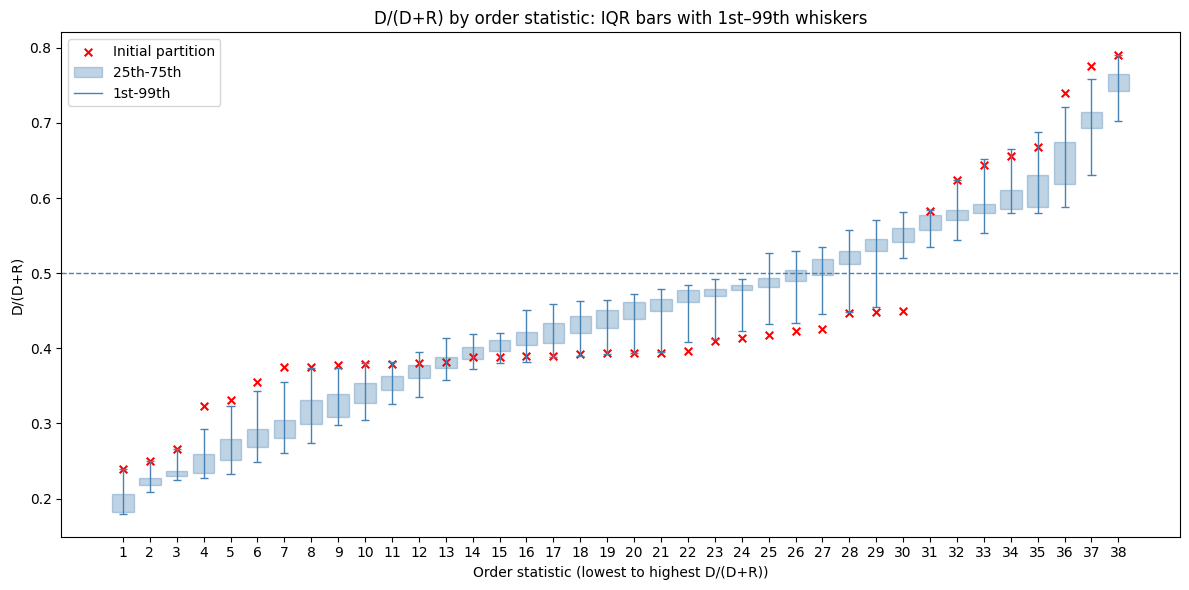

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Brute-force compute sorted D/(D+R) ratios for each assignment
ratios_per_assignment = []

# Parts are 1-indexed in this dataset
n_parts = len(tx_partition)
parts_list = list(range(1, n_parts + 1))

for assignment in assignment_list:
    # part -> [D, R]
    part_sums = {part: [0.0, 0.0] for part in parts_list}
    for node, part in assignment.mapping.items():
        data = modified_tx_graph.nodes[node]
        d = data.get("HarrisD_PRSG24", 0) or 0
        r = data.get("TrumpR_PRSG24", 0) or 0
        part_sums[part][0] += d
        part_sums[part][1] += r

    ratios = []
    for d, r in part_sums.values():
        total = d + r
        ratios.append(d / total if total else np.nan)

    ratios = np.array(ratios, dtype=float)
    # Sort low->high, keeping NaNs at the end
    ratios = np.sort(ratios)
    ratios_per_assignment.append(ratios)

# Stack into matrix: rows = assignments, cols = order stats
ratios_matrix = np.vstack(ratios_per_assignment)

q01 = np.nanpercentile(ratios_matrix, 1, axis=0)
q25 = np.nanpercentile(ratios_matrix, 25, axis=0)
q75 = np.nanpercentile(ratios_matrix, 75, axis=0)
q99 = np.nanpercentile(ratios_matrix, 99, axis=0)

x = np.arange(1, ratios_matrix.shape[1] + 1)

# Compute initial partition ratios for overlay
init_sums = {part: [0.0, 0.0] for part in parts_list}
for node, part in tx_partition.assignment.mapping.items():
    data = modified_tx_graph.nodes[node]
    d = data.get("HarrisD_PRSG24", 0) or 0
    r = data.get("TrumpR_PRSG24", 0) or 0
    init_sums[part][0] += d
    init_sums[part][1] += r

init_ratios = []
for d, r in init_sums.values():
    total = d + r
    init_ratios.append(d / total if total else np.nan)
init_ratios = np.sort(np.array(init_ratios, dtype=float))

plt.figure(figsize=(12, 6))

# Bar from 25th to 75th percentile
bar_heights = q75 - q25
plt.bar(x, bar_heights, bottom=q25, width=0.8, alpha=0.35, color="steelblue", edgecolor="steelblue", label="25th-75th")

# Whiskers from 1st to 99th percentile
for xi, lo, hi in zip(x, q01, q99):
    plt.vlines(xi, lo, hi, colors="steelblue", linewidth=1)
    plt.hlines([lo, hi], xi - 0.15, xi + 0.15, colors="steelblue", linewidth=1)

# Initial partition overlay as red X
plt.scatter(x, init_ratios, color="red", marker="x", s=30, label="Initial partition")

# Reference line at 0.5
plt.axhline(0.5, color="steelblue", linestyle="--", linewidth=1)

# Histogram-like x-axis ticks
plt.xticks(x)

plt.xlabel("Order statistic (lowest to highest D/(D+R))")
plt.ylabel("D/(D+R)")
plt.title("D/(D+R) by order statistic: IQR bars with 1st–99th whiskers")

# Legend (add whisker handle)
whisker_handle = Line2D([0], [0], color="steelblue", linewidth=1, label="1st-99th")
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(whisker_handle)
labels.append("1st-99th")
plt.legend(handles, labels)

plt.tight_layout()
plt.show()

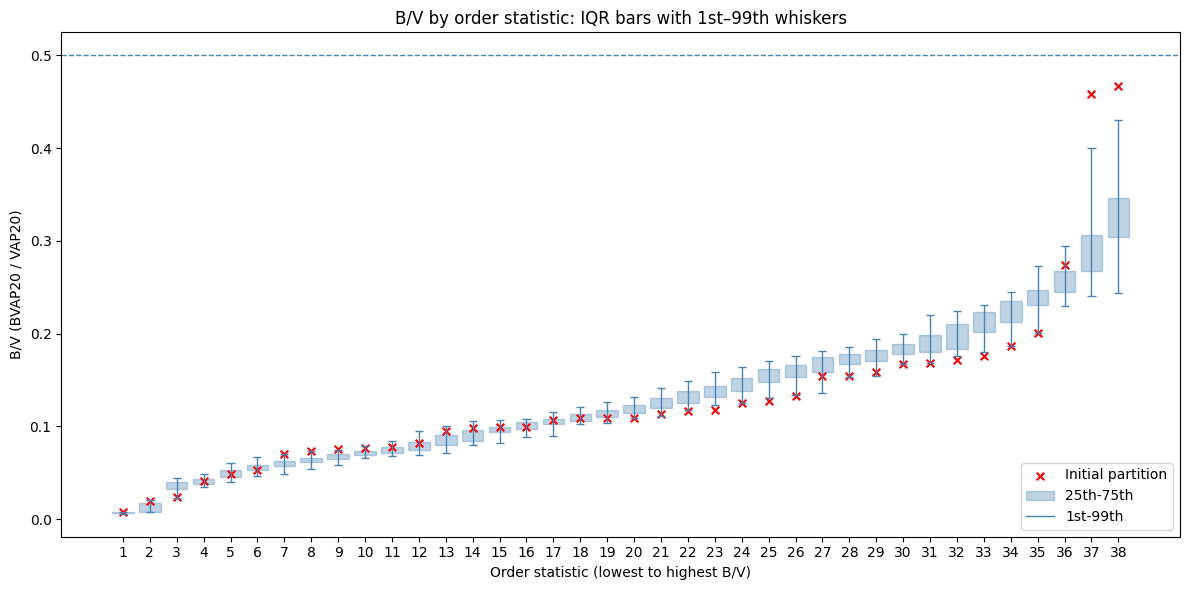

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Brute-force compute sorted B/V ratios for each assignment
ratios_per_assignment = []

# Parts are 1-indexed in this dataset
n_parts = len(tx_partition)
parts_list = list(range(1, n_parts + 1))

for assignment in assignment_list:
    # part -> [B, V]
    part_sums = {part: [0.0, 0.0] for part in parts_list}
    for node, part in assignment.mapping.items():
        data = modified_tx_graph.nodes[node]
        b = data.get("BVAP20", 0) or 0
        v = data.get("VAP20", 0) or 0
        part_sums[part][0] += b
        part_sums[part][1] += v

    ratios = []
    for b, v in part_sums.values():
        ratios.append(b / v if v else np.nan)

    ratios = np.array(ratios, dtype=float)
    ratios = np.sort(ratios)
    ratios_per_assignment.append(ratios)

ratios_matrix = np.vstack(ratios_per_assignment)

q01 = np.nanpercentile(ratios_matrix, 1, axis=0)
q25 = np.nanpercentile(ratios_matrix, 25, axis=0)
q75 = np.nanpercentile(ratios_matrix, 75, axis=0)
q99 = np.nanpercentile(ratios_matrix, 99, axis=0)

x = np.arange(1, ratios_matrix.shape[1] + 1)

# Compute initial partition ratios for overlay
init_sums = {part: [0.0, 0.0] for part in parts_list}
for node, part in tx_partition.assignment.mapping.items():
    data = modified_tx_graph.nodes[node]
    b = data.get("BVAP20", 0) or 0
    v = data.get("VAP20", 0) or 0
    init_sums[part][0] += b
    init_sums[part][1] += v

init_ratios = []
for b, v in init_sums.values():
    init_ratios.append(b / v if v else np.nan)
init_ratios = np.sort(np.array(init_ratios, dtype=float))

plt.figure(figsize=(12, 6))

bar_heights = q75 - q25
plt.bar(x, bar_heights, bottom=q25, width=0.8, alpha=0.35, color="steelblue", edgecolor="steelblue", label="25th-75th")

for xi, lo, hi in zip(x, q01, q99):
    plt.vlines(xi, lo, hi, colors="steelblue", linewidth=1)
    plt.hlines([lo, hi], xi - 0.15, xi + 0.15, colors="steelblue", linewidth=1)

plt.scatter(x, init_ratios, color="red", marker="x", s=30, label="Initial partition")

plt.axhline(0.5, color="steelblue", linestyle="--", linewidth=1)

plt.xticks(x)

plt.xlabel("Order statistic (lowest to highest B/V)")
plt.ylabel("B/V (BVAP20 / VAP20)")
plt.title("B/V by order statistic: IQR bars with 1st–99th whiskers")

whisker_handle = Line2D([0], [0], color="steelblue", linewidth=1, label="1st-99th")
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(whisker_handle)
labels.append("1st-99th")
plt.legend(handles, labels)

plt.tight_layout()
plt.show()

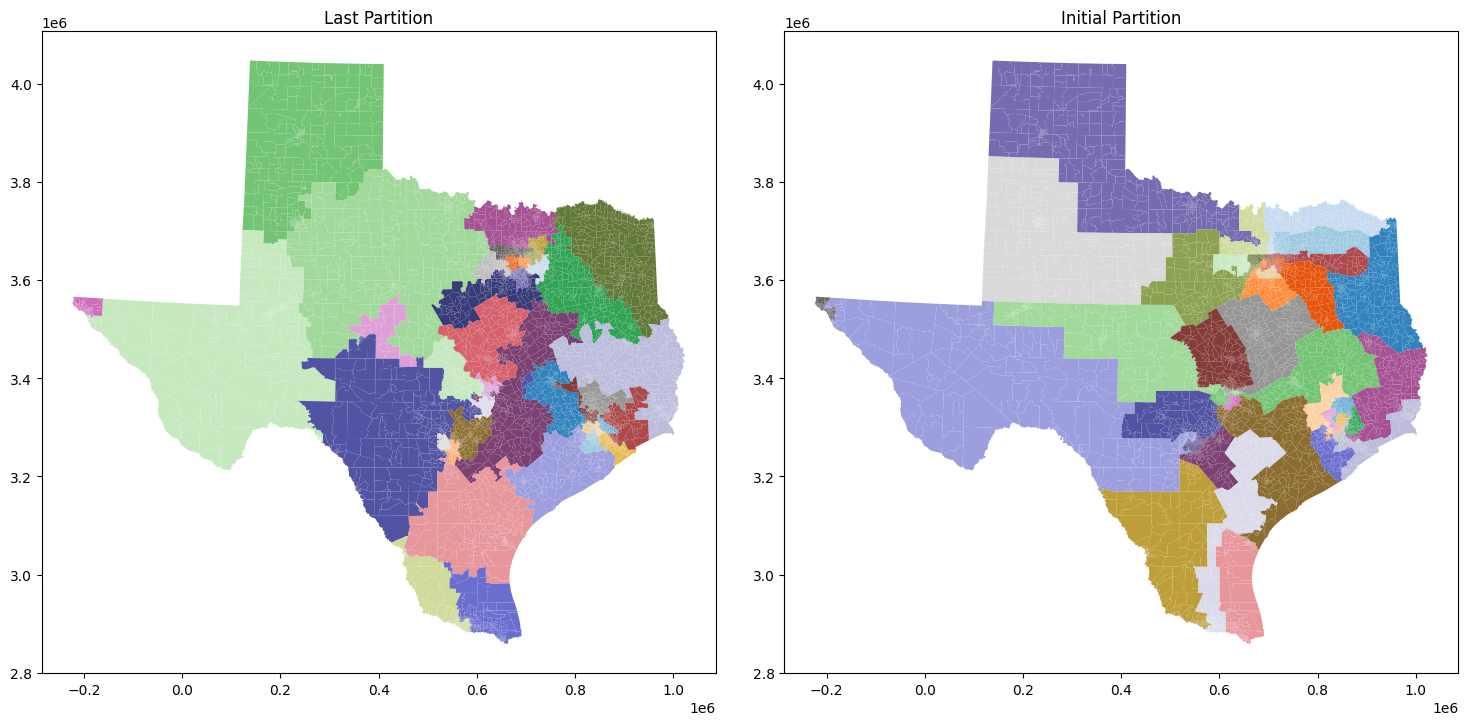

In [18]:
import matplotlib.pyplot as plt

last_assignment = assignment_list[-1]
last_partition = Partition(modified_tx_graph, assignment=last_assignment, updaters={"population": Tally("TOTPOP20", alias="population"), "VAP": Tally("VAP20", alias="VAP20")})
# plot them side by side with titles and unlabled axes
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
last_partition.plot(geometries=precinct_gdf, cmap = custom_cmap, ax=axes[0])
axes[0].set_title("Last Partition")
axes[0].set_xlabel("")
axes[0].set_ylabel("")
tx_partition.plot(geometries=precinct_gdf, cmap = custom_cmap, ax=axes[1])
axes[1].set_title("Initial Partition")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
plt.tight_layout()
plt.show()

In [27]:
last_df = last_assignment.to_series()
first_df = tx_partition.assignment.to_series()

merged_df = first_df.to_frame(name="initial").merge(last_df.to_frame(name="last"), left_index=True, right_index=True)
merged_df

,initial,last
0,19,10
1,19,10
2,19,10
3,19,10
7943,19,10
...,...,...
7675,22,1
7676,22,1
7677,22,1
7678,22,1


In [44]:
last_partition

<Partition [38 parts]>